In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn import preprocessing

oecd = pd.read_csv("oecd.csv")

sns.set_style("dark")

### Intro
We'll be looking at data from the OECD Better Life Index that includes a variety of indicators for quality of life. The figures are from 2017. First, we'll take a look at the data and pick out an interesting outcome variable as well as some others that could provide a basis for features with some explanatory value.

In [2]:
print('Columns: \n',oecd.columns,'\n')
print('Null values: \n',oecd.isnull().sum())
oecd.head()

Columns: 
 Index(['Country', 'Dwellings without basic facilities as pct',
       'Housing expenditure as pct', 'Rooms per person as rat',
       'Household net adjusted disposable income in usd',
       'Household net financial wealth in usd',
       'Labour market insecurity as pct', 'Employment rate as pct',
       'Long-term unemployment rate as pct', 'Personal earnings in usd',
       'Quality of support network as pct', 'Educational attainment as pct',
       'Student skills as avg score', 'Years in education in yrs',
       'Air pollution in ugm3', 'Water quality as pct',
       'Stakeholder engagement for developing regulations as avg score',
       'Voter turnout as pct', 'Life expectancy in yrs',
       'Self-reported health as pct', 'Life satisfaction as avg score',
       'Feeling safe walking alone at night as pct', 'Homicide rate as rat',
       'Employees working very long hours as pct',
       'Time devoted to leisure and personal care in hrs'],
      dtype='object') 

N

,Country,Dwellings without basic facilities as pct,Housing expenditure as pct,Rooms per person as rat,Household net adjusted disposable income in usd,Household net financial wealth in usd,Labour market insecurity as pct,Employment rate as pct,Long-term unemployment rate as pct,Personal earnings in usd,...,Water quality as pct,Stakeholder engagement for developing regulations as avg score,Voter turnout as pct,Life expectancy in yrs,Self-reported health as pct,Life satisfaction as avg score,Feeling safe walking alone at night as pct,Homicide rate as rat,Employees working very long hours as pct,Time devoted to leisure and personal care in hrs
0,Australia,1.1,20,2.3,33417,57462,4.3,72,1.36,52063,...,92,2.7,91,82.5,85,7.3,63.6,1.0,13.20,14.35
1,Austria,1.0,21,1.6,32544,59574,2.7,72,1.94,48295,...,93,1.3,75,81.3,70,7.0,80.7,0.4,6.78,14.55
2,Belgium,2.3,21,2.2,29968,104084,4.8,62,3.98,49587,...,84,2.2,89,81.1,75,6.9,70.7,1.0,4.31,15.77
3,Canada,0.2,22,2.5,29850,85758,3.9,73,0.81,48403,...,91,3.0,68,81.5,88,7.3,80.9,1.4,3.73,14.41
4,Chile,9.4,18,1.9,16588,21409,8.1,62,2.02,28434,...,69,1.5,49,79.1,57,6.7,51.1,4.5,10.06,14.90


As we can see from the above, most of the variables are continuous in nature, with the exception of each country's name. Of course, perhaps there are uses for some of the variables in a categorical fashion. I think it would be interesting to use life expectancy as the outcome variable, and build features out various other variables to construct a model. I think the following could be interesting variables to start with:
- Personal earnings, as a measure of financial resources
- Water quality as pct, as a potential proxy for environmental quality of the country
- Time devoted to leisure and personal care, as a measure for work/life balance
- Student skills as pct, as a potential measure of education
- Life satisfaction
- Dwellings without basic facilities as pct
- Region (just to have another categorical variable) - I'll have to create this

Let's explore these variables to get a sense of how they interrelate, which will help inform our feature engineering and selection.

In [3]:
# renaming columns to easier names
oecd = oecd.rename(columns={'Country':'country','Dwellings without basic facilities as pct':'pct_no_facilities','Life expectancy in yrs':'life_expectancy','Student skills as avg score':'student_scores','Time devoted to leisure and personal care in hrs':'leisure_time','Life satisfaction as avg score':'life_satisfaction','Personal earnings in usd':'earnings','Water quality as pct':'water_quality'})
# subset data to just interesting metrics
subset = oecd.loc[:,['country','life_expectancy','pct_no_facilities','student_scores','leisure_time','life_satisfaction','earnings','water_quality']]
# get rid of the "total" observation
subset = subset[subset['country'] != 'OECD - Total']

#dictionary for regions
regiondict = {'Asia':['Australia','Japan','South Korea','New Zealand'],'North America':['Canada','USA','Mexico'],
              'Western Europe':['Belgium','Denmark','Germany','France','Greece','Finland','Iceland','Ireland','Italy','Luxembourg','Netherlands','Norway','Portugal',
            'Spain','Sweden','Switzerland','United Kingdom'],'Africa':['South Africa'],'Eastern Europe':['Austria','Czech Republic','Estonia','Hungary', 'Russia','Latvia','Poland','Slovak Republic','Slovenia','Russia'],
             'Middle East':['Turkey','Israel'],'South America':['Chile','Brazil']}

#turn it into easier format to ingest into df
countrydict = {}
for key in regiondict:
    counter = 0
    for value in regiondict[key]:
        countrydict[value] = key

# add regions
subset['region'] = subset['country'].map(countrydict)

subset.head()

,country,life_expectancy,pct_no_facilities,student_scores,leisure_time,life_satisfaction,earnings,water_quality,region
0,Australia,82.5,1.1,502,14.35,7.3,52063,92,Asia
1,Austria,81.3,1.0,492,14.55,7.0,48295,93,Eastern Europe
2,Belgium,81.1,2.3,503,15.77,6.9,49587,84,Western Europe
3,Canada,81.5,0.2,523,14.41,7.3,48403,91,North America
4,Chile,79.1,9.4,443,14.90,6.7,28434,69,South America


/usr/local/lib/python3.6/site-packages/matplotlib/contour.py:967: UserWarning: The following kwargs were not used by contour: 'label', 'color'
  s)


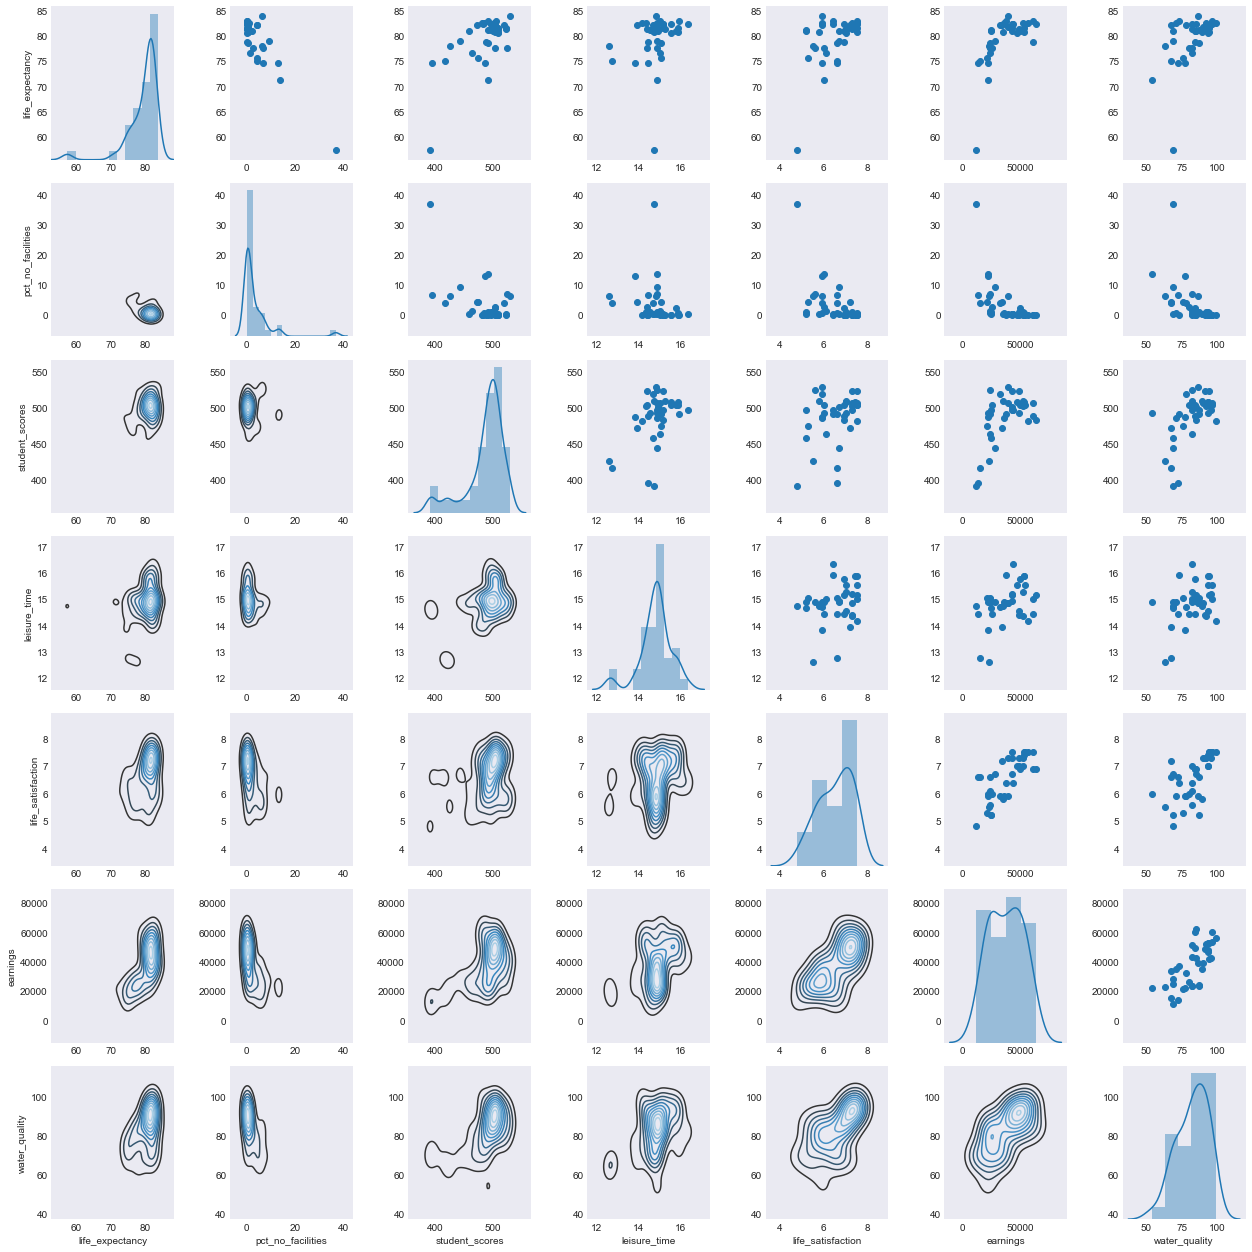

In [4]:
g = sns.PairGrid(subset, diag_sharey=False)
g.map_diag(sns.distplot)
g.map_lower(sns.kdeplot,cmap="Blues_d")
g.map_upper(plt.scatter)
plt.subplots_adjust(top=3)
plt.tight_layout()
plt.show()

From the above, it seems at first glance like plenty of the variables I've chosen could have a correlative relationship with the outcome variable, life expectancy. Additionally, some of the variables chosen seem to have correlative relationships with one another, such as water quality and earnings, earnings and life satisfaction, or student scores and water quality. These could point towards opportunities to use PCA in narrowing to the best features later on.

I can also already tell that some of the data might require some standardization of some form due to some big outliers (like dwellings with no facilities or student scores). Winsorizing or dropping data could be of use. Other variables (again like dwellings with no facilities) could benefit from applying a mathematical operation to the values to enforce a more normal distribution.

Let's dig deeper into the seeming correlation between some of the variables with a quick heatmap.

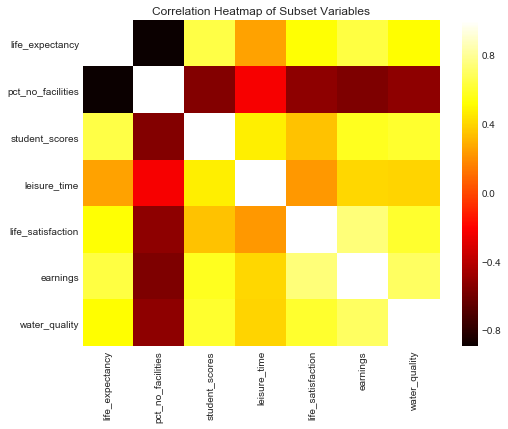

                   life_expectancy  pct_no_facilities  student_scores  \
life_expectancy           1.000000          -0.896214        0.647634   
pct_no_facilities        -0.896214           1.000000       -0.548758   
student_scores            0.647634          -0.548758        1.000000   
leisure_time              0.257314          -0.226152        0.472094   
life_satisfaction         0.520263          -0.524017        0.345818   
earnings                  0.641751          -0.566005        0.576176   
water_quality             0.513005          -0.519942        0.601196   

                   leisure_time  life_satisfaction  earnings  water_quality  
life_expectancy        0.257314           0.520263  0.641751       0.513005  
pct_no_facilities     -0.226152          -0.524017 -0.566005      -0.519942  
student_scores         0.472094           0.345818  0.576176       0.601196  
leisure_time           1.000000           0.224066  0.402020       0.395473  
life_satisfaction      0.

In [5]:
# creating the matrix and plotting the heat map
plt.figure(figsize=(8,6))
correlations = subset.corr()
sns.heatmap(correlations,cmap='hot')
plt.title("Correlation Heatmap of Subset Variables")
plt.show()
print(correlations)

Interestingly, life expectancy shows several strong negative correlations with a few different variables, and as we suspected water quality, life satisfaction, earnings, and student scores all demonstrate some interesting correlations among themselves.

Let's take another look at the extremity of outliers the original facet grid pointed to.

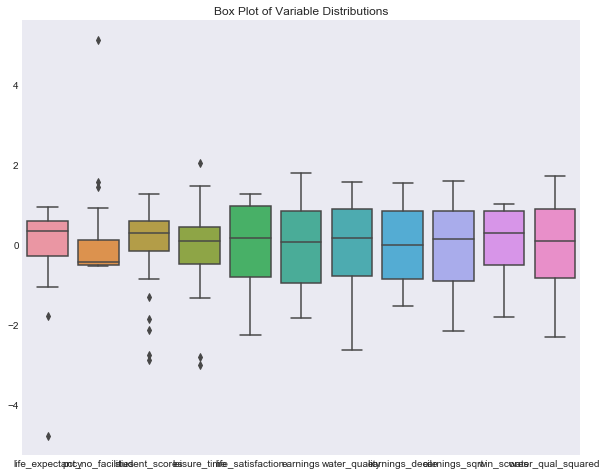

In [51]:
# first, we need to set them all to the same scales to compare the degree of outliers in each
# numeric columns
df_num = subset.select_dtypes(include=[np.number])
#scaling w/ scikit learn
scaled = pd.DataFrame(preprocessing.scale(df_num),columns=df_num.columns)

#plotting
plt.figure(figsize=(10,8))
sns.boxplot(data=scaled)
plt.title("Box Plot of Variable Distributions")
plt.show()

As we suspected, there's some extreme outliers for dwellings without facilities - we'll need to decide what to do with those. Additionally, student scores, life expectancy, and leisure time have some notable outliers we'll need to decide what to do with.

Lastly, let's look at how region affects life expectancy since that's our only categorical variable other than the country name itself.

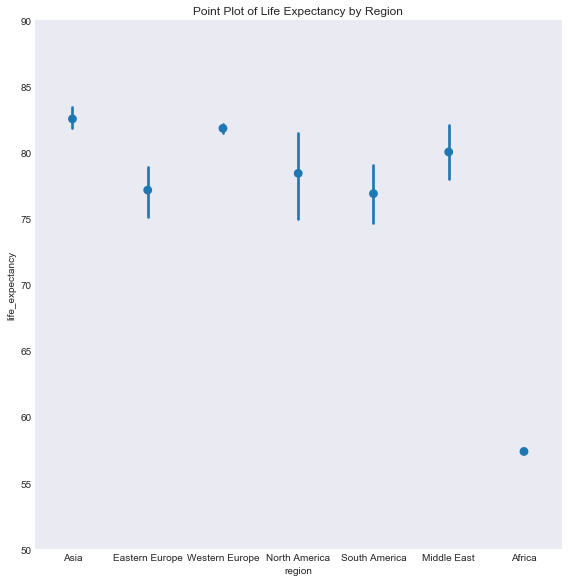

In [7]:
r = sns.factorplot(x='region',y='life_expectancy',data=subset,join=False,size=8)
plt.ylim(50,90)
plt.title("Point Plot of Life Expectancy by Region")
plt.show()

There's some big differences in life expectancy by region. This isn't explanatory in and of itself though in all likelihood, as the regions with high life expectancy are also generally richer and better educated, as we know.

# Features
Now that we've identified some interesting variables, it's time to expand on those to come up with a list of features we'd actually want to specifically use in a model. I'd like to include some variations on:
- Percentage of dwellings with no facilities, possibly with outliers winsorized or stripped
- Earnings Decile, in case very rich countries see diminishing returns in any corresponding increases in LE
- Square root of earnings, which may have a more normal distribution or perform better than the above
- Leisure time
- Student scores
- A winsorized version of student scores, since there are outliers that would indicate a larger gap in education than there might actually be
- A more normalized version of water quality
- Water quality
- Life satisfaction
- Region

We'll create the features and then get to the selection process. 

#### Percentage without facilities

In [8]:
plt.figure(figsize=(10,5))
subset[['country','life_expectancy','pct_no_facilities']].sort_values('pct_no_facilities',ascending=False).head(10)

,country,life_expectancy,pct_no_facilities
38,South Africa,57.4,37.0
37,Russia,71.3,13.8
19,Latvia,74.6,12.9
4,Chile,79.1,9.4
7,Estonia,77.7,6.9
36,Brazil,74.7,6.7
32,Turkey,78.0,6.5
17,Japan,83.9,6.4
15,Israel,82.1,4.4
12,Hungary,75.7,4.3


As we can see though, some of the countries with the highest percentage of dwellings without facilities also have the lowest life expectancy, so I think we'd be getting rid of some pretty critical observations by removing these. Ideally also we'd want to enforce a more normal distribution through a mathematical operation, but since the values are a percentage for whom some countries have value of zero, meaning that this may not be a valid method. So let's keep this original variable as the feature.

#### Earnings Deciles and Square Root of Earnings

In [9]:
# Decile
subset['earnings_decile'] = pd.qcut(subset['earnings'], 10, labels=False)

# Earnings squared
subset['earnings_sqrt'] = np.sqrt(subset['earnings'])

#### Leisure time
This variable looks like it has a decent correlation with the outcome variable, has a normal distribution, and is a continuous ratio variable such that there is less justification to winsorize the results in the way we might with student scores.

#### Student scores and the winsorized version
I think this could be an interesting point to look at, but want to include a winsorized version as well in the event that lower score outliers do not linearly lead to a decrease in life expectancy. For example, there may be a relationship between scores and life expectancy for scores within two or so SDs from the mean, but the large outliers on the low end we notice from the histogram may not have as poor life expectancy as their difference in scores might indicate. Grouping these back into the more "normal" range might increase predictive value.

In [10]:
# Winsorized student scores
subset['win_scores'] = stats.mstats.winsorize(subset['student_scores'],limits=(0.15,0.15))

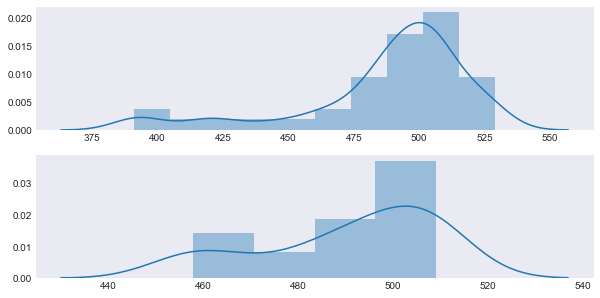

In [11]:
# Reviewing the two distributions
fig = plt.figure(figsize=(10,5))
fig.add_subplot(211)
sns.distplot(subset[['student_scores']])
fig.add_subplot(212)
sns.distplot(subset[['win_scores']])
plt.show()

#### Water quality
Water quality is another variable that would be interesting to include as a feature, but it could perhaps be made slightly more normal to enhance model performance. Let's compare it versus some other mathematically modified versions.

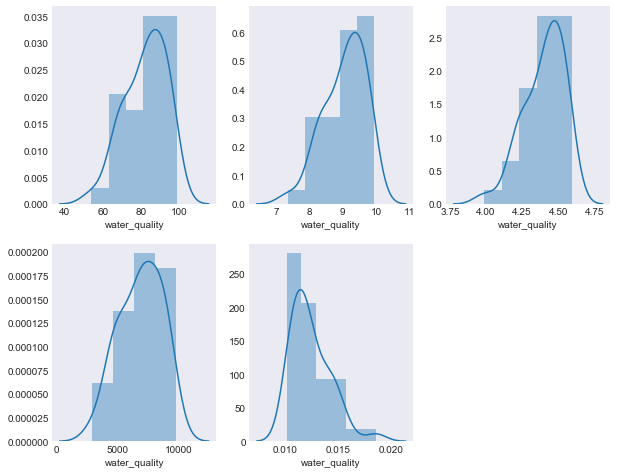

In [27]:
fig = plt.figure(figsize=(10,8))
fig.add_subplot(231)
sns.distplot(subset['water_quality'])
fig.add_subplot(232)
sns.distplot(np.sqrt(subset['water_quality']))
fig.add_subplot(233)
sns.distplot(np.log(subset['water_quality']))
fig.add_subplot(234)
sns.distplot(subset['water_quality']**2)
fig.add_subplot(235)
sns.distplot(1/subset['water_quality'])
plt.show()

In [13]:
subset['water_qual_squared'] = subset['water_quality']**2

While none of the above looks perfect, I do think the square of water_quality shows a slightly more normal distribution, so we'll use this to compare to the original variable feature.

#### Life Satisfaction
We'll keep this as is, since it has fixed bounds that I'd imagine may not react well to a mathematical operation.

#### Region
This may not work depending on what type of model we choose, but we'll keep it for now.

# Feature Selection
Now that we've got ten features, let's do some work to narrow them down to the five most useful.

/usr/local/lib/python3.6/site-packages/matplotlib/contour.py:967: UserWarning: The following kwargs were not used by contour: 'label', 'color'
  s)


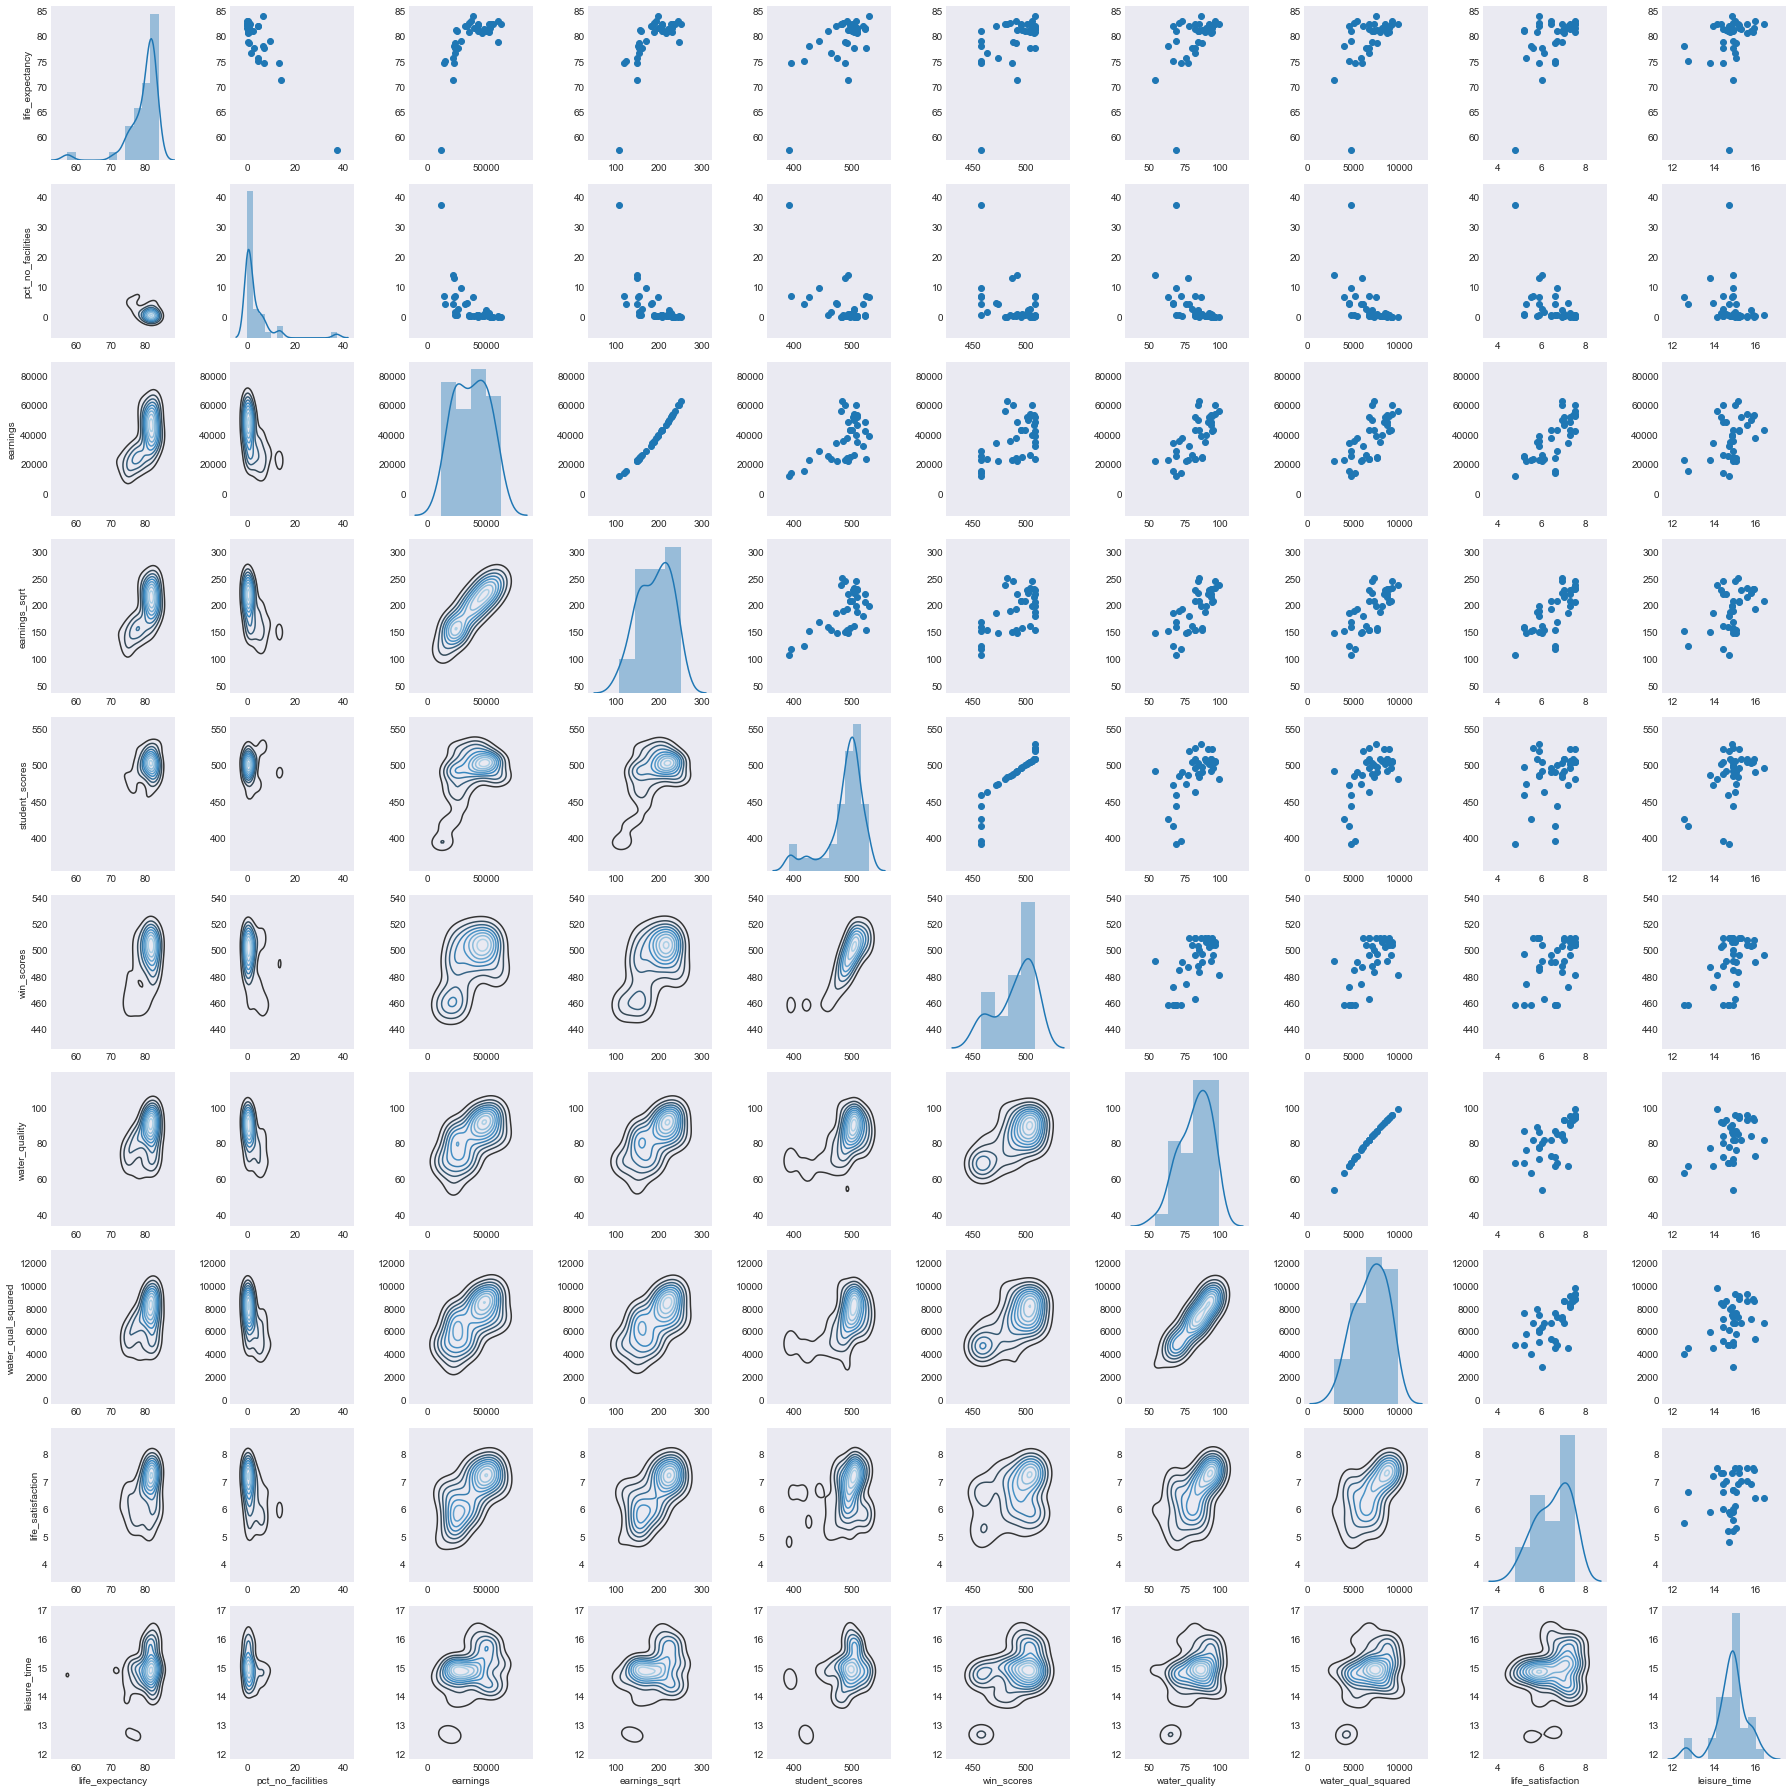

In [25]:
# Adding the chosen features into a new df

features = subset[['life_expectancy','pct_no_facilities','earnings','earnings_sqrt','student_scores','win_scores','water_quality','water_qual_squared','region','life_satisfaction','leisure_time']]

# Adding another pair grid to take a look at our features

g = sns.PairGrid(features, diag_sharey=False)
g.map_diag(sns.distplot)
g.map_lower(sns.kdeplot,cmap="Blues_d")
g.map_upper(plt.scatter)
plt.subplots_adjust(top=3)
plt.tight_layout()
plt.show()

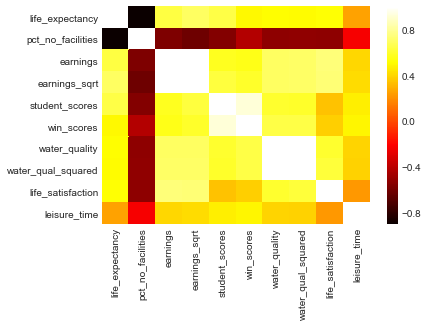

Correlations: 
                     life_expectancy  pct_no_facilities  earnings  \
life_expectancy            1.000000          -0.896214  0.641751   
pct_no_facilities         -0.896214           1.000000 -0.566005   
earnings                   0.641751          -0.566005  1.000000   
earnings_sqrt              0.696652          -0.608643  0.994886   
student_scores             0.647634          -0.548758  0.576176   
win_scores                 0.499455          -0.416433  0.562263   
water_quality              0.513005          -0.519942  0.699010   
water_qual_squared         0.506934          -0.513012  0.708257   
life_satisfaction          0.520263          -0.524017  0.743888   
leisure_time               0.257314          -0.226152  0.402020   

                    earnings_sqrt  student_scores  win_scores  water_quality  \
life_expectancy          0.696652        0.647634    0.499455       0.513005   
pct_no_facilities       -0.608643       -0.548758   -0.416433      -0.51994

In [55]:
# Correlation matrix
feature_correlations = features.corr()
sns.heatmap(feature_correlations,cmap='hot')

# feature variances - narrow to numeric columns
df_feat = features.select_dtypes(include=[np.number])
normalized_feat = (df_feat-df_feat.min())/(df_feat.max()-df_feat.min())

# just messing around with another way to do it w/ scikit
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(num_feat)
other_scaled = pd.DataFrame(x_scaled,columns=df_feat.columns)

plt.show()
print('Correlations: \n',feature_correlations,'\n')
print('Variances: \n',normalized_feat.var())

In [44]:
normalized_feat.head()

,life_expectancy,pct_no_facilities,earnings,earnings_sqrt,student_scores,win_scores,water_quality,water_qual_squared,life_satisfaction,leisure_time
0,0.947170,0.029730,0.793019,0.845228,0.804348,0.862745,0.844444,0.805810,0.925926,0.466844
1,0.901887,0.027027,0.719255,0.786314,0.731884,0.666667,0.866667,0.832680,0.814815,0.519894
2,0.894340,0.062162,0.744548,0.806766,0.811594,0.882353,0.666667,0.601307,0.777778,0.843501
3,0.909434,0.005405,0.721370,0.788034,0.956522,1.000000,0.822222,0.779230,0.925926,0.482759
4,0.818868,0.254054,0.330449,0.428164,0.376812,0.000000,0.333333,0.267974,0.703704,0.612732


The first thing we can do is narrow down multiple features derived from one variable to the best possible one for each. There are two feature variations on water quality, earnings, and student scores. Let's choose the ones with the highest correlations to the outcome variable of life expectancy.
- Student scores has a much higher correlation with the outcome variable than the winsorized version, so we'll stick with the original variable as a feature.
- Results for water quality are similar, so let's keep the squared, has similar correlative value but more variance.
- The square root of earnings correlates better than its counterpart, so we'll keep that feature.

That leaves us with seven features. I think we can also drop leisure time since its correlation to the outcome variable and normalized variance is notably below the others. We can probably also drop region since it would require six features to capture, and the regions with highest life expectancy are also those that we know are richer and more educated, meaning its correlative value is probably well captured elsewhere.

So now we have five features:
    - Student scores
    - Pct without facilities
    - Water quality squared
    - Life satisfaction
    - Square root of earnings
    
I think these would be great to model with, but just for fun let's perform a PCA analysis since we know that these features have correlations with one another, some of them quite strong.

In [49]:
features_culled = features.drop(axis=1,columns=['leisure_time','water_quality','win_scores','earnings','region'])
features_culled.head()

,life_expectancy,pct_no_facilities,earnings_sqrt,student_scores,water_qual_squared,life_satisfaction
0,82.5,1.1,228.173180,502,8464,7.3
1,81.3,1.0,219.761234,492,8649,7.0
2,81.1,2.3,222.681387,503,7056,6.9
3,81.5,0.2,220.006818,523,8281,7.3
4,79.1,9.4,168.623842,443,4761,6.7


In [48]:
culled_corr = features_culled.corr()
print(culled_corr)

                    life_expectancy  pct_no_facilities  earnings_sqrt  \
life_expectancy            1.000000          -0.896214       0.696652   
pct_no_facilities         -0.896214           1.000000      -0.608643   
earnings_sqrt              0.696652          -0.608643       1.000000   
student_scores             0.647634          -0.548758       0.631247   
water_qual_squared         0.506934          -0.513012       0.709575   
life_satisfaction          0.520263          -0.524017       0.738026   

                    student_scores  water_qual_squared  life_satisfaction  
life_expectancy           0.647634            0.506934           0.520263  
pct_no_facilities        -0.548758           -0.513012          -0.524017  
earnings_sqrt             0.631247            0.709575           0.738026  
student_scores            1.000000            0.598423           0.345818  
water_qual_squared        0.598423            1.000000           0.628226  
life_satisfaction         0.3458

In [80]:
sklearn_pca = PCA(n_components=5)
pca_feat = features_culled.drop(axis=1,columns=['life_expectancy'])
X = StandardScaler().fit_transform(pca_feat)
Y_sklearn = sklearn_pca.fit_transform(X)
var_ratios = sorted(list(sklearn_pca.explained_variance_ratio_),reverse=True)
component_variances = sorted(list(sklearn_pca.explained_variance_),reverse=True)

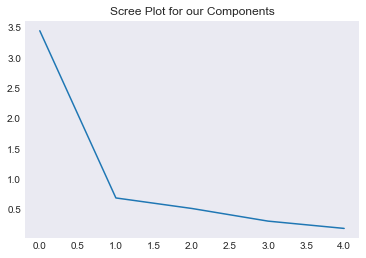

In [82]:
# Performing a scree plot to decide which ones to keep

sorted_eigenvals = sorted(component_variances,reverse=True)
plt.plot(sorted_eigenvals)
plt.title("Scree Plot for our Components")
plt.show()

Percent of variance explained by component 
 [0.6704378859368042, 0.1338970083593998, 0.10004734042704148, 0.05950983222794026, 0.036107933048814246]


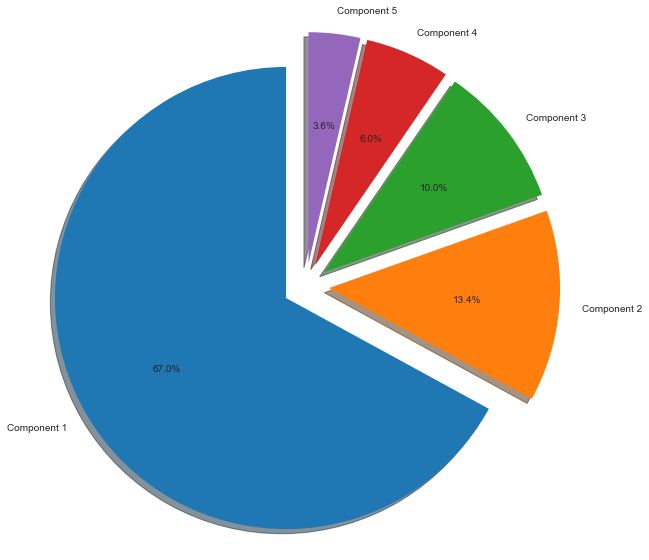

In [98]:
print('Percent of variance explained by component \n',var_ratios)

labels = 'Component 1', 'Component 2', 'Component 3', 'Component 4','Component 5'
sizes = var_ratios
explode = (0.1, 0.1, 0.1, 0.1,0.1)

fig1, ax1 = plt.subplots(figsize=(10,10))
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

By the rule of eigenvalues > 1, we would amazingly only need to include the first component resulting from our PCA analysis. If we were to include the first two, we'd capture over 80% of the variance between these ***5*** variables. Since we already have room for all five, we can stick with the features we chose, but it's worth noting that they could be greatly condensed without losing much variance if we needed to reduce features further or add others.